Mérés: RSA 1024 bit, ECC secp192r1, kyber512...
RSA 1024 bit: 613 iteráció 1 perc alatt.
ECC secp192r1: 1239 iteráció 1 perc alatt.
Kyber-512: 1744 iteráció 1 perc alatt.
Mérés: RSA 2048 bit, ECC secp224r1, kyber512...
RSA 2048 bit: 57 iteráció 1 perc alatt.
ECC secp224r1: 865 iteráció 1 perc alatt.
Kyber-512: 1736 iteráció 1 perc alatt.
Mérés: RSA 3072 bit, ECC secp256r1, kyber512...
RSA 3072 bit: 17 iteráció 1 perc alatt.
ECC secp256r1: 656 iteráció 1 perc alatt.
Kyber-512: 1725 iteráció 1 perc alatt.
Mérés: RSA 7680 bit, ECC secp384r1, kyber512...
RSA 7680 bit: 1 iteráció 1 perc alatt.
ECC secp384r1: 269 iteráció 1 perc alatt.
Kyber-512: 1675 iteráció 1 perc alatt.


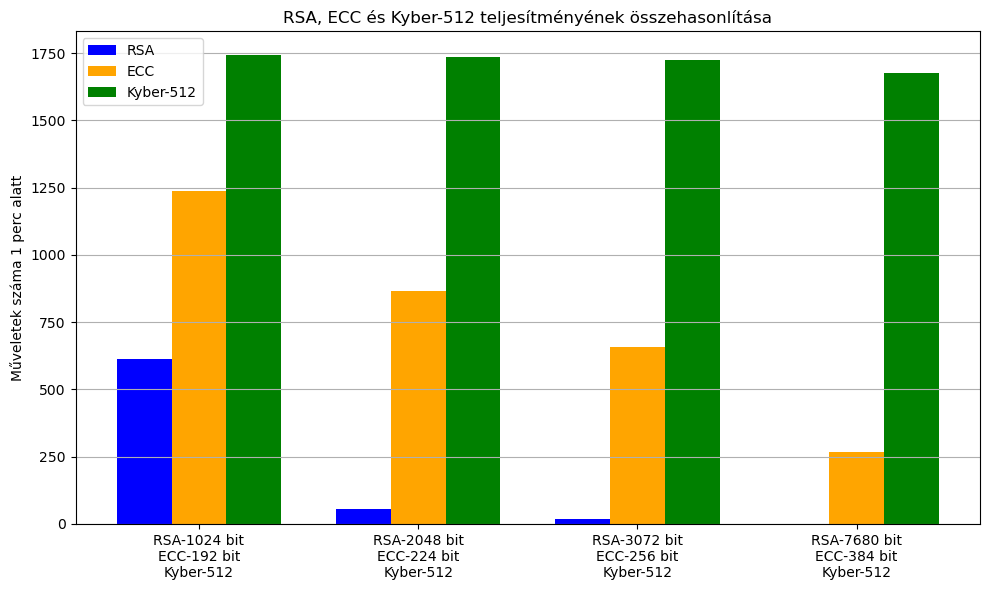

Mérés befejezve.


In [5]:
#! pip install tinyec matplotlib pycryptodome
# pyky könyvtár elérhetősége: https://github.com/asdfjkl/pyky

import time
import matplotlib.pyplot as plt
from Crypto.PublicKey import RSA
from Crypto.Cipher import PKCS1_OAEP
from tinyec import registry
from ccakem import kem_keygen512, kem_encaps512, kem_decaps512
import secrets

# RSA, ECC és Kyber kulcsméretek különböző biztonsági szinteken
szintek = {
    1: {"rsa": 1024, "ecc": "secp192r1", "kyber": "kyber512"},
    2: {"rsa": 2048, "ecc": "secp224r1", "kyber": "kyber512"},
    3: {"rsa": 3072, "ecc": "secp256r1", "kyber": "kyber512"},
    4: {"rsa": 7680, "ecc": "secp384r1", "kyber": "kyber512"},
}

# RSA iterációk mérése 1 perces időtartamban
def rsa_iteraciok_merese(kulcsmeret, ido=60):
    uzenet = b"Ez egy 256 bites teszt uzenet!"
    iteracios_szam = 0
    kezd_ido = time.time()

    while time.time() - kezd_ido < ido:
        rsa_kulcs = RSA.generate(kulcsmeret)
        rsa_nyilvanos_kulcs = rsa_kulcs.publickey()
        titkosito = PKCS1_OAEP.new(rsa_nyilvanos_kulcs)
        visszafejto = PKCS1_OAEP.new(rsa_kulcs)

        rsa_titkositott = titkosito.encrypt(uzenet)
        rsa_visszafejtett = visszafejto.decrypt(rsa_titkositott)
        assert uzenet == rsa_visszafejtett, "Hiba: A visszafejtett üzenet nem egyezik az eredetivel!"
        iteracios_szam += 1

    return iteracios_szam

# ECC iterációk mérése 1 perces időtartamban
def ecc_iteraciok_merese(gorbe_nev, ido=60):
    gorbe = registry.get_curve(gorbe_nev)
    iteracios_szam = 0
    kezd_ido = time.time()

    while time.time() - kezd_ido < ido:
        privat_kulcs = secrets.randbelow(gorbe.field.n)
        nyilvanos_kulcs = privat_kulcs * gorbe.g

        masik_privat_kulcs = secrets.randbelow(gorbe.field.n)
        masik_nyilvanos_kulcs = masik_privat_kulcs * gorbe.g

        megosztott_kulcs = privat_kulcs * masik_nyilvanos_kulcs
        megosztott_kulcs_visszafejtett = masik_privat_kulcs * nyilvanos_kulcs
        assert megosztott_kulcs == megosztott_kulcs_visszafejtett, "Hiba: A megosztott kulcsok nem egyeznek!"
        iteracios_szam += 1

    return iteracios_szam

# Kyber-512 iterációk mérése 1 perces időtartamban
def kyber_iteraciok_merese(ido=60):
    iteracios_szam = 0
    kezd_ido = time.time()

    while time.time() - kezd_ido < ido:
        privat_kulcs, nyilvanos_kulcs = kem_keygen512()
        megosztott_kulcs_enc, titkositott_szoveg = kem_encaps512(nyilvanos_kulcs)
        megosztott_kulcs_dec = kem_decaps512(privat_kulcs, titkositott_szoveg)
        assert megosztott_kulcs_enc == megosztott_kulcs_dec, "Hiba: A megosztott kulcsok nem egyeznek!"
        iteracios_szam += 1

    return iteracios_szam

# Eredmények tárolása
rsa_iteraciok = []
ecc_iteraciok = []
kyber_iteraciok = []

# Mérések elvégzése minden szinten
for szint, kulcsok in szintek.items():
    rsa_kulcsmeret = kulcsok["rsa"]
    ecc_gorbe_nev = kulcsok["ecc"]
    kyber_tipus = kulcsok["kyber"]
    
    print(f"Mérés: RSA {rsa_kulcsmeret} bit, ECC {ecc_gorbe_nev}, {kyber_tipus}...")
    
    rsa_szam = rsa_iteraciok_merese(rsa_kulcsmeret, ido=60)
    ecc_szam = ecc_iteraciok_merese(ecc_gorbe_nev, ido=60)
    kyber_szam = kyber_iteraciok_merese(ido=60)
    
    rsa_iteraciok.append(rsa_szam)
    ecc_iteraciok.append(ecc_szam)
    kyber_iteraciok.append(kyber_szam)

    print(f"RSA {rsa_kulcsmeret} bit: {rsa_szam} iteráció 1 perc alatt.")
    print(f"ECC {ecc_gorbe_nev}: {ecc_szam} iteráció 1 perc alatt.")
    print(f"Kyber-512: {kyber_szam} iteráció 1 perc alatt.")

# X tengely címkék
ecc_kulcsmeretek = {
    "secp192r1": 192,
    "secp224r1": 224,
    "secp256r1": 256,
    "secp384r1": 384
}
x_cimkek = [f"RSA-{kulcsok['rsa']} bit\nECC-{ecc_kulcsmeretek[kulcsok['ecc']]} bit\nKyber-512" for szint, kulcsok in szintek.items()]

# Diagram rajzolása
plt.figure(figsize=(10, 6))
x = range(len(szintek))
szelesseg = 0.25

plt.bar([p - szelesseg for p in x], rsa_iteraciok, szelesseg, label="RSA", color="blue")
plt.bar(x, ecc_iteraciok, szelesseg, label="ECC", color="orange")
plt.bar([p + szelesseg for p in x], kyber_iteraciok, szelesseg, label="Kyber-512", color="green")
plt.xticks(ticks=x, labels=x_cimkek)
plt.ylabel("Műveletek száma 1 perc alatt")
plt.title("RSA, ECC és Kyber-512 teljesítményének összehasonlítása")
plt.legend()
plt.grid(axis="y")
plt.tight_layout()

# Diagram megjelenítése
plt.show()

print("Mérés befejezve.")
